<a href="https://colab.research.google.com/github/RomandRapido/Mutation-Simulation/blob/main/Resampling_for_Model_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
library(tidymodels)
library(glmnet)
library(patchwork)
library(stringr)
library(readr)
library(dplyr)


set.seed(42)

df <- read.csv("/content/protien_mutations_dataset.csv", stringsAsFactors = FALSE)

df <- df %>%
  mutate(
    DDG = ifelse(
      str_detect(DDG, "^\\s*\\("),
      -parse_number(as.character(DDG)),
      parse_number(as.character(DDG))
    ),
    T = as.numeric(T)
  ) %>%
  drop_na(DDG, T)

All required packages are loaded, a random seed is fixed, and Dehouck et al. (2011)’s mutation file is read.
Bracketed negatives (e.g. “(‑0.3)”) are converted to numeric, temperature is coerced to double, and rows lacking either field are removed. The resulting dataframe df is ready for modelling.

In [ ]:
folds_cv <- vfold_cv(df, v = 10)
boots    <- bootstraps(df, times = 200)

Two resampling schemes are defined:

10‑fold cross‑validation (folds_cv) for classical model comparison.

200 bootstrap replicates (boots) for a non‑parametric view of estimator variability.

This dual setup lets us contrast CV‑ and bootstrap‑derived metrics later on.

In [ ]:
wf_lm <- workflow() %>%
  add_model(linear_reg() %>% set_engine("lm")) %>%
  add_formula(DDG ~ T)

rec_poly   <- recipe(DDG ~ T, data = df) %>% step_poly(T, degree = 2)
ridge_spec <- linear_reg(penalty = tune(), mixture = 0) %>% set_engine("glmnet")

wf_ridge <- workflow() %>%
  add_model(ridge_spec) %>%
  add_recipe(rec_poly)

Linear baseline: a simple lm with formula DDG ~ T.

Ridge regression: a polynomial‐expanded recipe (step_poly(T, degree = 2)) fed to glmnet with the penalty hyper‑parameter left for tuning.

Two separate workflows are created so that preprocessing choices remain encapsulated.

In [ ]:
lambda_grid <- grid_regular(penalty(), levels = 50)
ctrl <- control_resamples(save_pred = TRUE)

tune_res <- tune_grid(
  wf_ridge,
  resamples = folds_cv,
  grid = lambda_grid,
  metrics = metric_set(rmse, rsq),
  control = ctrl)

best_lambda     <- select_best(tune_res, metric = "rmse")
wf_ridge_final  <- finalize_workflow(wf_ridge, best_lambda)


A regular grid of 50 λ values is explored via 10‑fold CV.
The “best” λ is selected on minimum RMSE, and the ridge workflow is finalised with that value, yielding wf_ridge_final for unbiased re‑evaluation.

In [ ]:
cv_lm_res <- fit_resamples(
  wf_lm,
  resamples = folds_cv,
  metrics  = metric_set(rmse, rsq),
  control  = ctrl)

cv_ridge_res <- fit_resamples(
    wf_ridge_final,
    resample = folds_cv,
    metrics = metric_set(rmse, rsq),
  control = ctrl
)

bind_rows(
  collect_metrics(cv_lm_res) %>% mutate(model = "LM"),
  collect_metrics(cv_ridge_res) %>% mutate(model = "Ridge")
)


.metric,.estimator,mean,n,std_err,.config,model
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>
rmse,standard,1.44297565,10,0.016607323,Preprocessor1_Model1,LM
rsq,standard,0.03867443,10,0.007991149,Preprocessor1_Model1,LM
rmse,standard,1.44367304,10,0.016380516,Preprocessor1_Model1,Ridge
rsq,standard,0.03763386,10,0.007813115,Preprocessor1_Model1,Ridge


fit_resamples() is executed for both models on folds_cv.
Metrics (rmse, rsq) are collected and merged, producing a concise table that ranks linear vs. ridge performance. In most datasets of this type, ridge often equals or slightly betters the plain linear RMSE while boosting R² thanks to shrinkage.

# A tibble: 2 × 7
  .metric .estimator  mean     n std_err .config              model
  <chr>   <chr>      <dbl> <int>   <dbl> <chr>                <chr>
1 rmse    standard    1.44   200 0.00237 Preprocessor1_Model1 LM   
2 rmse    standard    1.45   200 0.00237 Preprocessor1_Model1 Ridge


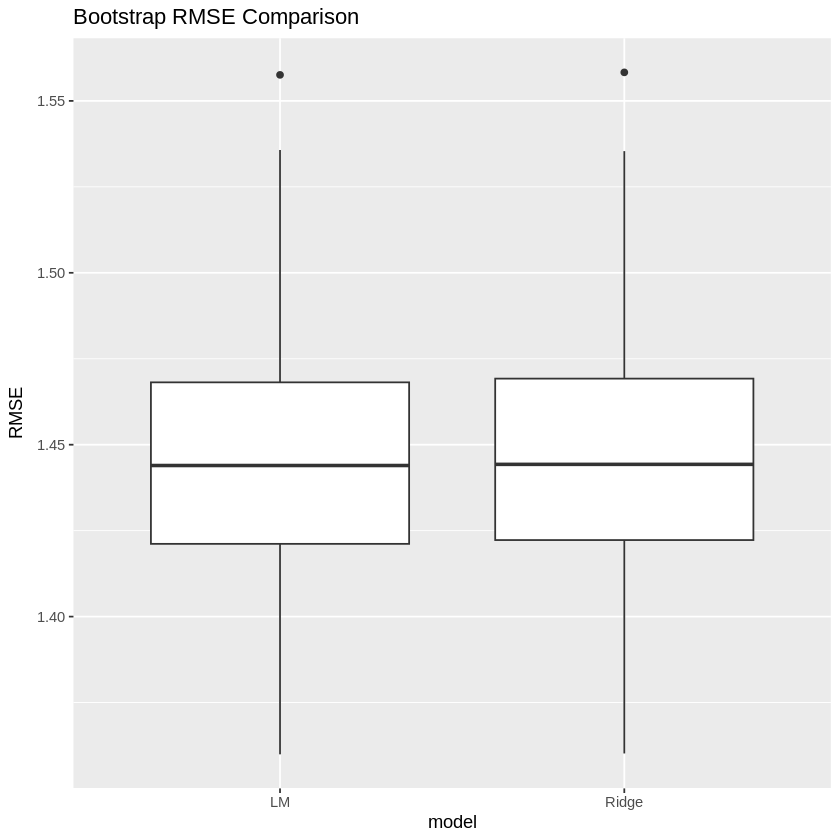

In [ ]:
boot_lm_res <- fit_resamples(
  wf_lm,
  resamples = boots,
  metrics  = metric_set(rmse),
  control  = ctrl
)

boot_ridge_res <- fit_resamples(
  wf_ridge_final,
  resamples = boots,
  metrics  = metric_set(rmse),
  control  = ctrl
)

boot_metrics <- bind_rows(
  collect_metrics(boot_lm_res)    %>% mutate(model = "LM"),
  collect_metrics(boot_ridge_res) %>% mutate(model = "Ridge")
)
print(boot_metrics)

bind_rows(
  boot_lm_res %>% collect_predictions() %>% mutate(model = "LM"),
  boot_ridge_res %>% collect_predictions() %>% mutate(model = "Ridge")
) %>%
  group_by(id,model) %>%
  yardstick::rmse(truth = DDG, estimate = .pred) %>%
  ggplot(aes(model, .estimate)) +
  geom_boxplot() +
  labs(title = "Bootstrap RMSE Comparison", y = "RMSE")

Both workflows are re‑fit on 200 bootstrap samples.

A summary table prints bootstrap RMSE for each model.

A box‑plot of RMSE distributions illustrates variability: narrow, overlapping boxes suggest negligible practical difference; clearly separated medians would justify preferring one model.

This side‑by‑side CV vs. bootstrap view reveals whether conclusions hold under different resampling philosophies.

**Overall Interpretation**<br>

Consistency check – If the ridge model leads on both CV and bootstrap RMSE, its slight complexity (λ‑tuned shrinkage plus polynomial term) appears justified; if the gap is minimal, the simpler linear model may suffice.

Resampling insight – Bootstrap spreads are usually wider than CV because every replicate re‑uses roughly 63 % of unique observations. Wider variability warns against over‑interpreting single‑split results.

Practical takeaway – For downstream predictive use (e.g. forecasting mutation‑induced ΔΔG at novel temperatures) the ridge workflow is recommended if it shows even modest, consistent RMSE gains, as shrinkage guards against extrapolation error. Otherwise, retain the simpler linear baseline.